In [213]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
from scipy.interpolate import RBFInterpolator, InterpolatedUnivariateSpline
import scipy.special as special
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

import os
os.chdir(os.getcwd())

In [214]:
N = 15       # number of loops
lc = 0.12     # magnetic core length / m
l = 7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # degauss frequency
T = 20       # deguass time
# R = 1 * 3.6 / 6  # resistance calculate
R = 1.55
gain = 15
samp_rate = 5000
n_sample = samp_rate * T
dt = 1/samp_rate

In [215]:
def get_data(fname,off_set):
    Vin = []
    Vpick = []
    for i in off_set:
        with h5py.File(fname, "a") as f:
            dset = f[f"{i}off"]
            Vin.append(dset[0])
            Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_general_data(fname,rname,off_set):
    Vin = []
    Vpick = []
    with h5py.File(fname, "a") as f:
        dset = f[rname]
        Vin.append(dset[0])
        Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_off(fname,runname = "off"):
    off_set = []
    off_get = []
    with h5py.File(fname, "a") as f:
        dset = f[runname]
        off_set.append(dset[0])
        off_get.append(dset[1])
    return np.array(off_set[0]), np.array(off_get[0])

def off_fit(off_set,off_get):
    coef = np.polyfit(off_set, off_get, 1)
    poly1d_fn = np.poly1d(coef) 
    return poly1d_fn

def test_func(x, a ,b, c,d):
    return a * np.exp(-b*x) * np.sin(c *2*np.pi* x + d)

def expdcysin_fit(raw_data, Vset,time_stamp, fre, time_factor):
    # x_data = np.linspace(0 , 1/fre, len(raw_data))
    x_data = time_stamp
    y_data = raw_data
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[Vset,1,time_factor*fre,0])
    plt.plot(x_data, y_data,"-", label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1],params[2],params[3]),"-",label='Fitted function',color = "r")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    return params, x_data

def off_subtract(Vin,Vpick,off_set,fitfun):
    input_off_fit = fitfun(off_set)/1000/3.6
    input_off_mea = np.mean(Vin[-10000:-1])
    print(input_off_mea)
    print(input_off_fit)
    Vin_sub = Vin - input_off_mea
    pick_off_mea = np.mean(Vpick[-10000:-1])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [479]:
file_name = "C:\\Users\\yuanhang.yang\\Documents\\GitHub\\new_cavity\\degauss_4_1_2024.hdf"
off_file_name = "off_set.hdf"
off = [0]
#Vpick, Vin = get_data(file_name,off)   # get both input voltage and pickup voltage
Vin, Vpick = get_general_data(file_name,"noamp9Vpp4Hz50off1kHz",off)
time_stamp = np.linspace(0,T,len(Vin))
off_set, off_get = get_off(off_file_name)        # get offset calibration measured before
off_fit_fun = off_fit(off_set, off_get) 

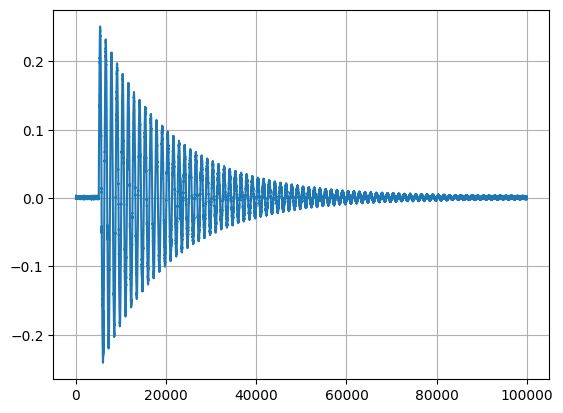

In [480]:
plt.plot(Vin)
plt.grid(True)

In [481]:
pos_peaks,_ = find_peaks(Vpick,distance=1000, height = max(Vpick)-0.2)
neg_peaks,_ = find_peaks(-Vpick,distance=1000, height = max(Vpick)-0.2)
print(pos_peaks[0:4])
print(neg_peaks[0:4])
print(neg_peaks[1] - pos_peaks[0])
print(pos_peaks[1] - neg_peaks[1])
time_used = time_stamp[pos_peaks[1]-10:-1]
Vin_used  = Vin[pos_peaks[1]-10:-1] 
Vpick_used = Vpick[pos_peaks[1]-10:-1]
Vin_mea, Vpick_mea = off_subtract(Vin_used,Vpick_used,off[0],off_fit_fun)
# Vin_mea = Vin_used
# Vpick_mea = Vpick_used
I = Vin_mea /R
H = np.array(I) * N / lc

[ 6345  7597  8849 10101]
[5719 6971 8222 9474]
626
626
0.000711133042170806
7.588888888888942e-05


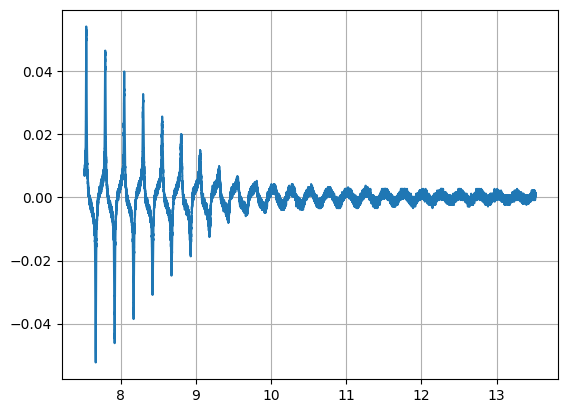

In [482]:
start = 30000
stop = 60000
m = np.s_[start:stop]
plt.plot(time_used[m],Vpick_mea[m])
plt.grid(True)

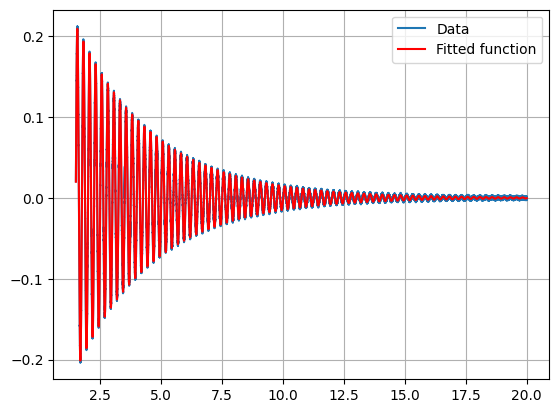

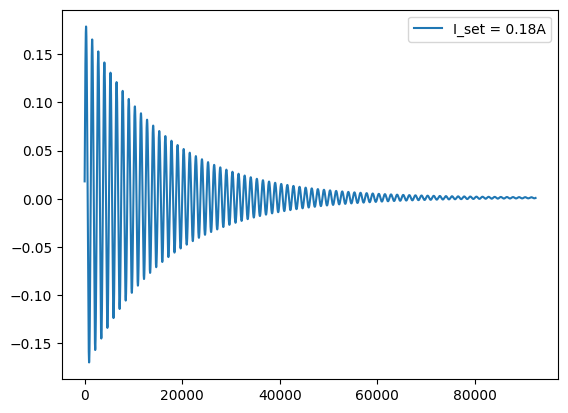

In [483]:
amp_fit = []
derate_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
Vamp = 4.5 * 2 
param,x = expdcysin_fit(Vin_mea,Vamp,time_used,4,1)
amp_fit.append(param[0])
derate_fit.append(param[1])
fre_fit.append(param[2])
phase_fit.append(param[3])
# if param[0] > 0:
#     V_SGamp.append((2 * Vamp - 2*abs(param[0]))/2)
# else:
#     V_SGamp.append((-1* (2 * Vamp - 2*abs(param[0])))/2)

data_fit = test_func(x,param[0] , param[1],param[2],param[3])
V_SGamp = (2 * Vamp - max(abs(data_fit)))/2
convert_factor = V_SGamp / max(abs(data_fit))
I = []
I_set = np.array(Vamp)/50

V_SG = data_fit * convert_factor +0.05
I= (V_SG)/50
plt.plot(I, label  = "I_set = "+ str(I_set) + "A")
plt.legend()

In [484]:
off = 0.075
off_coil = off / convert_factor
H_off = off_coil / R * N /lc
print(H_off)
slope = 0.1/H_off/u0
print("calculated ur is: ", slope )

0.14238228699518646
calculated ur is:  558900.0796752054


In [487]:
B = []
B_int = []
Bini = [0]
Vini = [0]
dB = np.array(Vpick_mea)/Ac/N/gain
#print("magnetic field difference between pos & neg peak:",dB[pos_peaks[0]] + dB[neg_peaks[0]] )
print(len(dB))
H = np.array(I) * N / lc
for a in dB[0:-1]:
        Bini.append(Bini[-1] + (a-0.00)* dt )
B.append(Bini)

92412


Text(0, 0.5, 'B (T)')

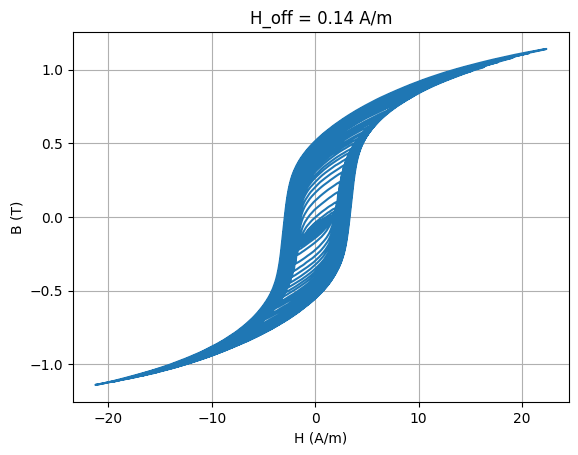

In [488]:
start = 0000
stop = 80000
m = np.s_[start:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
plt.grid(True)
plt.title("H_off = 0.14 A/m")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")

Text(0, 0.5, 'B (T)')

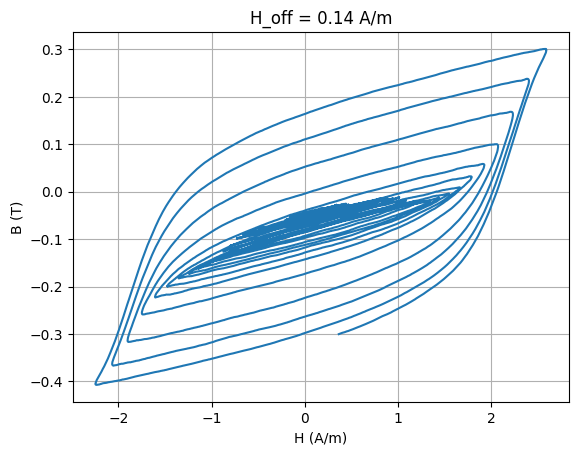

In [491]:
start = 35000
stop = 90000
m = np.s_[start:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
plt.grid(True)
plt.title("H_off = 0.14 A/m")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")

In [ ]:
off = [0,0.05,0.1]
H_off = np.array(off) / convert_factor / R * N /lc
B_settle = [-0.055,0]